In [2]:
%pip install dash dash-core-components dash-html-components dash-table plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 57.9 MB/s eta 0:00:00


#Launch Success Count For All Sites

In [2]:
# Import necessary libraries
import pandas as pd
import plotly.express as px
from dash import Dash, html, dcc

# Initialize the Dash app
app = Dash(__name__)

# Load the dataset
# The dataset is provided as 'spacex_comprehensive_launches.csv'
try:
    spacex_df = pd.read_csv('spacex_comprehensive_launches.csv')
except FileNotFoundError:
    print("Error: 'spacex_comprehensive_launches.csv' not found. Please ensure the file is in the correct directory.")
    exit()

# --- Data Preprocessing for Pie Chart ---
# Assuming 'Class' column indicates success (1) or failure (0)
# Calculate the success count for each site
# Sum of 'Class' per 'Launch Site' gives the number of successful launches
successful_launches_per_site = spacex_df[spacex_df['Class'] == 1].groupby('Launch Site').size().reset_index(name='Successful Launches')

# Calculate the total launches for each site
total_launches_per_site = spacex_df.groupby('Launch Site').size().reset_index(name='Total Launches')

# Merge the two dataframes to get successful and total launches for each site
site_summary_df = pd.merge(successful_launches_per_site, total_launches_per_site, on='Launch Site', how='right').fillna(0)

# Calculate success percentage
site_summary_df['Success Percentage'] = (site_summary_df['Successful Launches'] / site_summary_df['Total Launches']) * 100

# Handle cases where Total Launches might be 0 to avoid division by zero (though unlikely in this dataset)
site_summary_df['Success Percentage'] = site_summary_df['Success Percentage'].replace([float('inf'), -float('inf')], 0).fillna(0)


# --- Dash App Layout ---
app.layout = html.Div([
    html.H1("SpaceX Launch Success Analysis", style={'textAlign': 'center', 'color': '#503D36', 'font-size': 40}),
    html.Div([
        html.H2("Success Percentage by Launch Site", style={'textAlign': 'center'}),
        # Pie Chart for Success Percentage among all sites
        dcc.Graph(id='success-pie-chart')
    ], style={'padding': '20px', 'backgroundColor': '#f9f9f9', 'borderRadius': '10px', 'margin': '20px auto', 'maxWidth': '800px'})
])

# --- Dash App Callbacks ---
@app.callback(
    Output('success-pie-chart', 'figure'),
    Input('success-pie-chart', 'id') # Dummy input, as the chart is static based on initial data
)
def update_pie_chart(dummy_input):
    """
    Generates a pie chart showing the success percentage for each launch site.
    """
    # Create pie chart using Plotly Express
    # 'names' will be the labels (Launch Site) and 'values' will be the sizes of the slices (Success Percentage)
    fig = px.pie(site_summary_df,
                 values='Success Percentage',
                 names='Launch Site',
                 title='Total Success Launches by Site',
                 hover_data=['Successful Launches', 'Total Launches'], # Show additional info on hover
                 color_discrete_sequence=px.colors.qualitative.Pastel) # Choose a color sequence

    fig.update_traces(textposition='inside', textinfo='percent+label') # Display percentage and label inside slices
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, port=8050)


Columns in the DataFrame: Index(['Flight No.', 'FlightNumber', 'Date', 'Time', 'Launchoutcome',
       'Outcome', 'BoosterVersion', 'Version Booster', 'Launch site',
       'LaunchSite', 'Longitude', 'Latitude', 'Payload', 'PayloadMass',
       'Orbit', 'Customer', 'Serial', 'Flights', 'GridFins', 'Reused', 'Legs',
       'Block', 'ReusedCount', 'Booster landing', 'LandingPad'],
      dtype='object')


<IPython.core.display.Javascript object>

#Launch Site With Highest Launch Success

In [3]:
# Import required libraries
import pandas as pd
import dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output
import plotly.express as px

# Read the airline data into pandas dataframe
# Changed to use the correct file name and handle potential FileNotFoundError
try:
    spacex_df = pd.read_csv("spacex_comprehensive_launches.csv")
except FileNotFoundError:
    print("Error: 'spacex_comprehensive_launches.csv' not found. Please ensure the file is in the correct directory.")
    exit()

# Adjust max_payload and min_payload to use the correct column name 'PayloadMass'
max_payload = spacex_df['PayloadMass'].max()
min_payload = spacex_df['PayloadMass'].min()

# Create a dash application
app = dash.Dash(__name__)

# Create an app layout
app.layout = html.Div(children=[html.H1('SpaceX Launch Records Dashboard',
                                        style={'textAlign': 'center', 'color': '#503D36',
                                               'font-size': 40}),
                                # TASK 1: Add a dropdown list to enable Launch Site selection
                                dcc.Dropdown(id='site-dropdown',
                                 options=[
                                {'label': 'All Sites', 'value': 'ALL'},
                                # Ensure these values match the actual 'LaunchSite' column values in your CSV
                                {'label': 'CCAFS LC-40', 'value': 'CCAFS LC-40'},
                                {'label': 'VAFB SLC-4E', 'value': 'VAFB SLC-4E'},
                                {'label':'KSC LC-39A','value': 'KSC LC-39A'},
                                 {'label':'CCAFS SLC-40','value': 'CCAFS SLC-40'}
                                 ],
                                 value='ALL',
                                 placeholder="Select a Launch Site here",
                                 searchable=True
                                 ),
                                html.Br(),

                                # TASK 2: Add a pie chart to show the total successful launches count for all sites
                                # If a specific launch site was selected, show the Success vs. Failed counts for the site
                                html.Div(dcc.Graph(id='success-pie-chart')),
                                html.Br(),

                                html.P("Payload range (Kg):"),
                                # TASK 3: Add a slider to select payload range
                                dcc.RangeSlider(id='payload-slider',
                                                min=0,
                                                max=10000, # Assuming max payload in your data is around 10000kg
                                                step=1000,
                                                marks={0: '0', 2500: '2500', 5000: '5000', 7500: '7500', 10000: '10000'},
                                                value=[min_payload, max_payload]), # Set default value based on actual min/max payload
                                # TASK 4: Add a scatter chart to show the correlation between payload and launch success
                                html.Div(dcc.Graph(id='success-payload-scatter-chart')),
                                ])

# TASK 2:
# Add a callback function for `site-dropdown` as input, `success-pie-chart` as output
@app.callback(Output(component_id='success-pie-chart', component_property='figure'),
              Input(component_id='site-dropdown', component_property='value'))
def get_pie_chart(entered_site):
    if entered_site == 'ALL':
        # Use 'Outcome' column for values and names for all sites
        # Get counts of each outcome (e.g., 'Success', 'Failure') across all sites
        outcome_counts = spacex_df['Outcome'].value_counts().reset_index()
        outcome_counts.columns = ['Outcome', 'Count']
        fig = px.pie(outcome_counts, values='Count',
        names='Outcome',
        title='Total Launch Outcomes Across All Sites')
        return fig
    else:
        # Filter dataframe for the selected site
        filtered_df = spacex_df[spacex_df['LaunchSite'] == entered_site]
        # Get counts of each outcome for the selected site
        outcome_counts = filtered_df['Outcome'].value_counts().reset_index()
        outcome_counts.columns = ['Outcome', 'Count']
        fig = px.pie(outcome_counts, values='Count',
        names='Outcome',
        title=f'Launch Outcomes for Site: {entered_site}')
        return fig

# TASK 4:
# Add a callback function for `site-dropdown` and `payload-slider` as inputs, `success-payload-scatter-chart` as output
@app.callback(
          Output(component_id='success-payload-scatter-chart', component_property='figure'),
          [Input(component_id='site-dropdown', component_property='value'),
          Input(component_id="payload-slider", component_property="value")])

def get_scatter_plot(entered_site,payload_mass):
    lower,upper=payload_mass
    # Filter by payload range using 'PayloadMass'
    filtered_df_payload = spacex_df[(spacex_df['PayloadMass'] >= lower) & (spacex_df['PayloadMass'] <= upper)]

    if entered_site=='ALL':
        fig = px.scatter(filtered_df_payload,
                         x='PayloadMass', # Corrected column name
                         y='Outcome', # Using 'Outcome' for success/failure on y-axis
                         color='BoosterVersion', # Corrected column name
                         title='Correlation between Payload and Success for All Sites')
        return fig
    else:
        # Further filter by launch site if a specific site is selected
        filtered_df_site_payload = filtered_df_payload[filtered_df_payload['LaunchSite'] == entered_site]
        fig = px.scatter(filtered_df_site_payload,
                         x='PayloadMass', # Corrected column name
                         y='Outcome', # Using 'Outcome' for success/failure on y-axis
                         color='BoosterVersion', # Corrected column name
                         title=f'Correlation between Payload and Success for Site: {entered_site}')
        return fig

# Run the app
if __name__ == '__main__':
    app.run(debug=True, port=8050)


/tmp/ipython-input-3-2741386159.py:4: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

/tmp/ipython-input-3-2741386159.py:5: UserWarning:


The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`



<IPython.core.display.Javascript object>

#Payload vs.Launch Outcome

In [6]:
# Import required libraries
import pandas as pd
import dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output
import plotly.express as px

# Read the airline data into pandas dataframe
# Changed to use the correct file name and handle potential FileNotFoundError
try:
    spacex_df = pd.read_csv("spacex_comprehensive_launches.csv")
except FileNotFoundError:
    print("Error: 'spacex_comprehensive_launches.csv' not found. Please ensure the file is in the correct directory.")
    exit()

# Adjust max_payload and min_payload to use the correct column name 'PayloadMass'
max_payload = spacex_df['PayloadMass'].max()
min_payload = spacex_df['PayloadMass'].min()

# Create a dash application
app = dash.Dash(__name__)

# Create an app layout
app.layout = html.Div(children=[html.H1('SpaceX Launch Records Dashboard',
                                        style={'textAlign': 'center', 'color': '#503D36',
                                               'font-size': 40}),
                                # TASK 1: Add a dropdown list to enable Launch Site selection
                                dcc.Dropdown(id='site-dropdown',
                                 options=[
                                {'label': 'All Sites', 'value': 'ALL'},
                                # Ensure these values match the actual 'LaunchSite' column values in your CSV
                                {'label': 'CCAFS LC-40', 'value': 'CCAFS LC-40'},
                                {'label': 'VAFB SLC-4E', 'value': 'VAFB SLC-4E'},
                                {'label':'KSC LC-39A','value': 'KSC LC-39A'},
                                 {'label':'CCAFS SLC-40','value': 'CCAFS SLC-40'}
                                 ],
                                 value='ALL',
                                 placeholder="Select a Launch Site here",
                                 searchable=True
                                 ),
                                html.Br(),

                                # TASK 2: Add a pie chart to show the total successful launches count for all sites
                                # If a specific launch site was selected, show the Success vs. Failed counts for the site
                                html.Div(dcc.Graph(id='success-pie-chart')),
                                html.Br(),

                                html.P("Payload range (Kg):"),
                                # TASK 3: Add a slider to select payload range
                                dcc.RangeSlider(id='payload-slider',
                                                min=0,
                                                max=10000, # Assuming max payload in your data is around 10000kg
                                                step=1000,
                                                marks={0: '0', 2500: '2500', 5000: '5000', 7500: '7500', 10000: '10000'},
                                                value=[min_payload, max_payload]), # Set default value based on actual min/max payload
                                # TASK 4: Add a scatter chart to show the correlation between payload and launch success
                                html.Div(dcc.Graph(id='success-payload-scatter-chart')),
                                ])

# TASK 2:
# Add a callback function for `site-dropdown` as input, `success-pie-chart` as output
@app.callback(Output(component_id='success-pie-chart', component_property='figure'),
              Input(component_id='site-dropdown', component_property='value'))
def get_pie_chart(entered_site):
    if entered_site == 'ALL':
        # Filter for successful launches
        successful_launches_df = spacex_df[spacex_df['Outcome'] == 'Success']

        # Count successful launches per site
        site_success_counts = successful_launches_df['LaunchSite'].value_counts().reset_index()
        site_success_counts.columns = ['LaunchSite', 'Successful Launches Count']

        fig = px.pie(site_success_counts,
                     values='Successful Launches Count',
                     names='LaunchSite',
                     title='Percentage of Successful Launches by Site (Overall Success)')
        # Update traces to show percentages
        fig.update_traces(textposition='inside', textinfo='percent+label')
        return fig
    else:
        # Filter dataframe for the selected site
        filtered_df = spacex_df[spacex_df['LaunchSite'] == entered_site].copy()

        # Map all non-success outcomes to 'Failure' for a clear binary representation
        # Assuming 'Success' is the exact string used for successful launches in the 'Outcome' column.
        # If your data uses 1 for success and 0 for failure, adjust this line:
        # filtered_df['LaunchResultCategory'] = filtered_df['Outcome'].apply(lambda x: 'Success' if x == 1 else 'Failure')
        filtered_df['LaunchResultCategory'] = filtered_df['Outcome'].apply(lambda x: 'Success' if x == 'Success' else 'Failure')

        outcome_counts = filtered_df['LaunchResultCategory'].value_counts().reset_index()
        outcome_counts.columns = ['Category', 'Count'] # Renaming columns for clarity in the pie chart
        fig = px.pie(outcome_counts, values='Count',
                     names='Category', # Use the new category column
                     title=f'Success vs. Failure Rate for Site: {entered_site}')
        # Update traces to show percentages
        fig.update_traces(textposition='inside', textinfo='percent+label')
        return fig

# TASK 4:
# Add a callback function for `site-dropdown` and `payload-slider` as inputs, `success-payload-scatter-chart` as output
@app.callback(
          Output(component_id='success-payload-scatter-chart', component_property='figure'),
          [Input(component_id='site-dropdown', component_property='value'),
          Input(component_id="payload-slider", component_property="value")])

def get_scatter_plot(entered_site,payload_mass):
    lower,upper=payload_mass
    # Filter by payload range using 'PayloadMass'
    filtered_df_payload = spacex_df[(spacex_df['PayloadMass'] >= lower) & (spacex_df['PayloadMass'] <= upper)]

    if entered_site=='ALL':
        fig = px.scatter(filtered_df_payload,
                         x='PayloadMass', # Corrected column name
                         y='Outcome', # Using 'Outcome' for success/failure on y-axis
                         color='BoosterVersion', # Corrected column name
                         title='Correlation between Payload and Success for All Sites')
        return fig
    else:
        # Further filter by launch site if a specific site is selected
        filtered_df_site_payload = filtered_df_payload[filtered_df_payload['LaunchSite'] == entered_site]
        fig = px.scatter(filtered_df_site_payload,
                         x='PayloadMass', # Corrected column name
                         y='Outcome', # Using 'Outcome' for success/failure on y-axis
                         color='BoosterVersion', # Corrected column name
                         title=f'Correlation between Payload and Success for Site: {entered_site}')
        return fig

# Run the app
if __name__ == '__main__':
    app.run(debug=True, port=8050)


<IPython.core.display.Javascript object>

Pie chart saved to launch_success_pie_chart.png


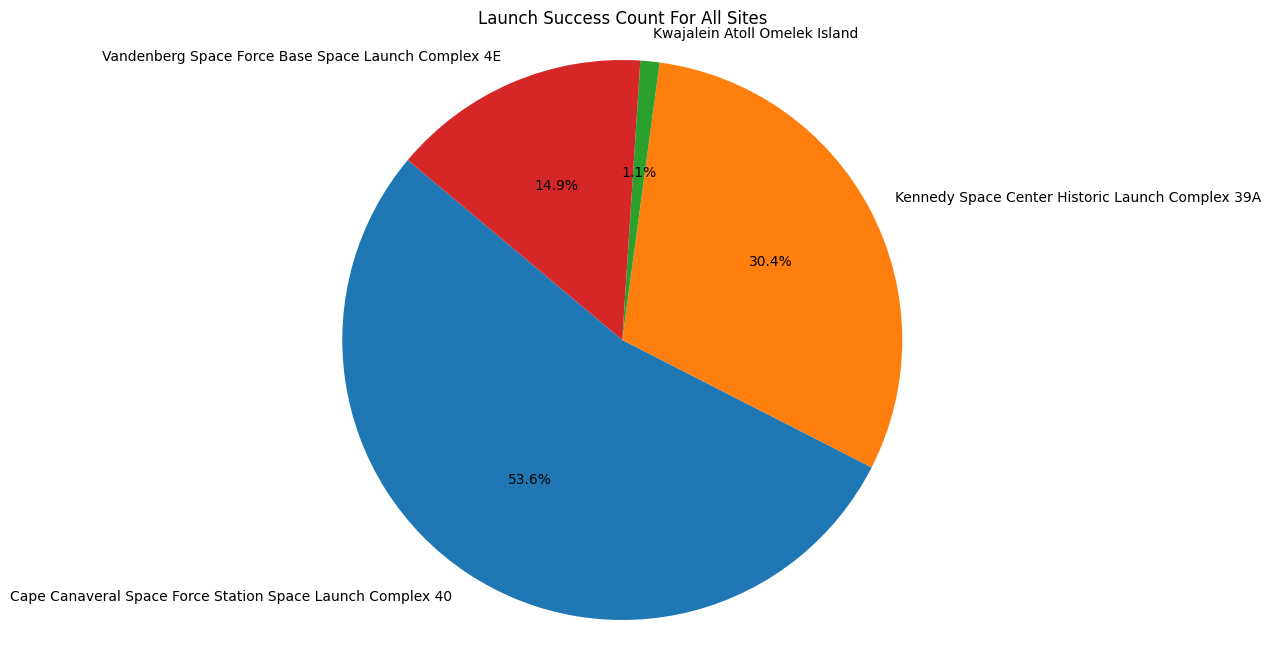

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('spacex_comprehensive_launches.csv')

# Filter for successful launches using the correct column name 'Launchoutcome'
successful_launches_by_site = df[df['Launchoutcome'] == True].groupby('LaunchSite').size()

# Create a pie chart
plt.figure(figsize=(10, 8))
plt.pie(successful_launches_by_site, labels=successful_launches_by_site.index, autopct='%1.1f%%', startangle=140)
plt.title('Launch Success Count For All Sites')
plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('launch_success_pie_chart.png')

print("Pie chart saved to launch_success_pie_chart.png")

#launch with Success rate

Pie chart representing launch success rates saved to launch_success_rate_pie_chart.png


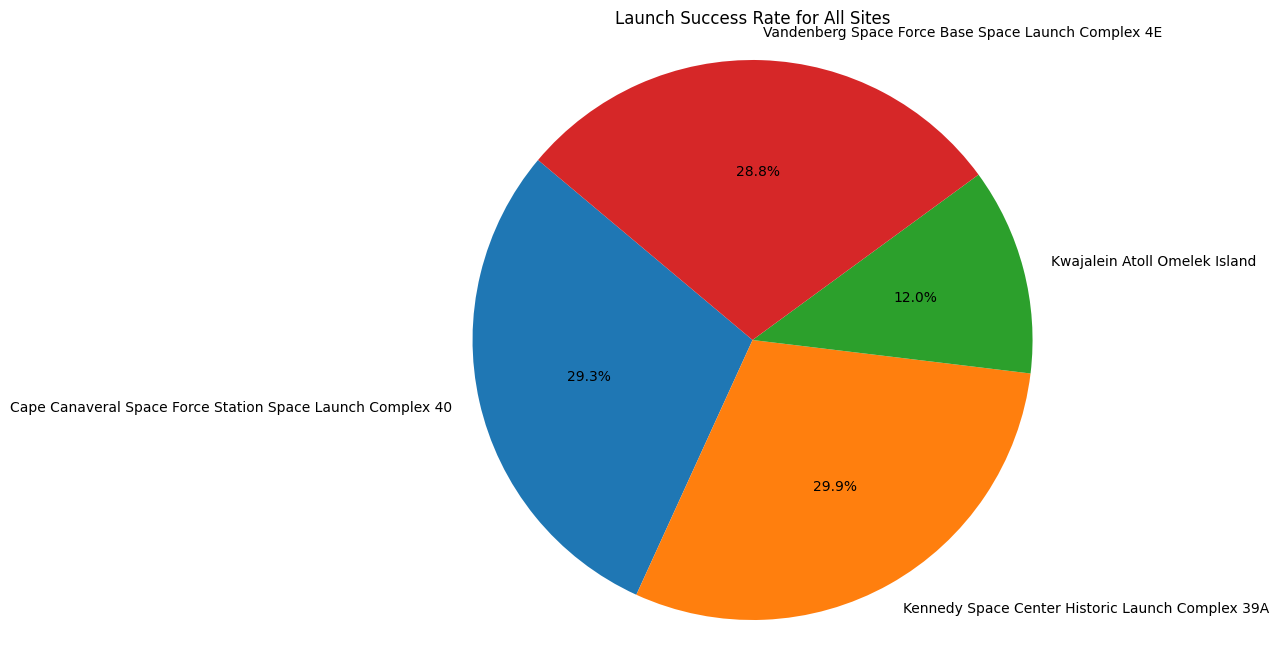

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('spacex_comprehensive_launches.csv')

# Calculate total launches per site
total_launches_by_site = df.groupby('LaunchSite').size().rename('TotalLaunches')

# Calculate successful launches per site
successful_launches_by_site = df[df['Launchoutcome'] == True].groupby('LaunchSite').size().rename('SuccessfulLaunches')

# Combine into a single DataFrame for easier calculation and merge with total launches
launch_summary = pd.DataFrame(total_launches_by_site).join(successful_launches_by_site)

# Fill NaN values with 0 for sites with no successful launches
launch_summary['SuccessfulLaunches'] = launch_summary['SuccessfulLaunches'].fillna(0)

# Calculate success rate
launch_summary['SuccessRate'] = (launch_summary['SuccessfulLaunches'] / launch_summary['TotalLaunches']) * 100

# Create a pie chart for success rates
plt.figure(figsize=(10, 8))
plt.pie(launch_summary['SuccessRate'], labels=launch_summary.index, autopct='%1.1f%%', startangle=140)
plt.title('Launch Success Rate for All Sites')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.savefig('launch_success_rate_pie_chart.png')

print("Pie chart representing launch success rates saved to launch_success_rate_pie_chart.png")

/tmp/ipython-input-10-1880780885.py:10: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



Scatter plot saved to payload_mass_vs_launch_outcome_scatter.png


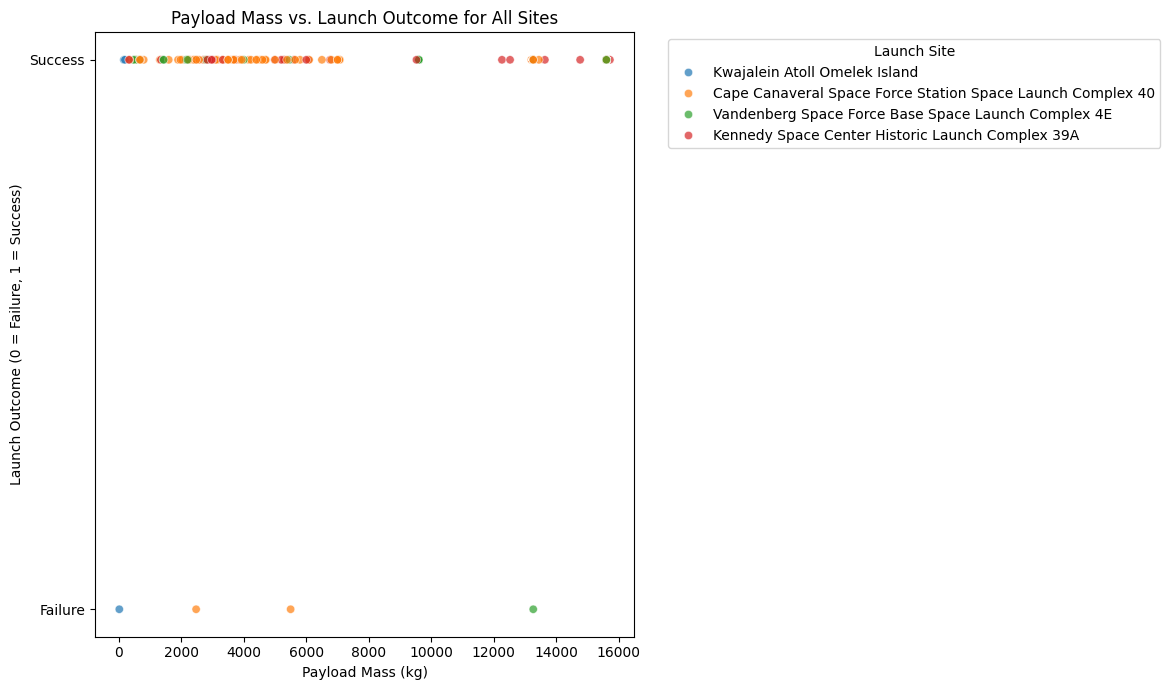

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('spacex_comprehensive_launches.csv')

# Handle NaN values in 'Launchoutcome' before converting to numeric
# Fill NaN with False, then convert boolean to integer (False=0, True=1)
df['Launchoutcome_numeric'] = df['Launchoutcome'].fillna(False).astype(int)

# Create the scatter plot
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='PayloadMass', y='Launchoutcome_numeric', hue='LaunchSite', alpha=0.7)

# Set labels and title
plt.title('Payload Mass vs. Launch Outcome for All Sites')
plt.xlabel('Payload Mass (kg)')
plt.ylabel('Launch Outcome (0 = Failure, 1 = Success)')
plt.yticks([0, 1], ['Failure', 'Success']) # Set custom y-axis ticks and labels for clarity

# Add legend to differentiate sites
plt.legend(title='Launch Site', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent legend from overlapping
plt.tight_layout()

# Save the plot
plt.savefig('payload_mass_vs_launch_outcome_scatter.png')

print("Scatter plot saved to payload_mass_vs_launch_outcome_scatter.png")